<a href="https://colab.research.google.com/github/project-mlx/mlx-case-studies/blob/main/job_recommedation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Job Reccomendaer Systems
## Please go through the following insta post for more details https://www.instagram.com/p/CKBI9kUp4Mi/

Datasets: indeed.com datasets (https://drive.google.com/drive/folders/1zULL590k7dz9_5AiDh330GIrDho8P6CN?usp=sharing)

- Cleaning Jobs and user Datasets
- Prepreprcessing Datasets
- Feature Extraction
- Reccomendation generation using Cosine Similarity and KNN

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

**Reading the Jobs details dataset and applying NLP preprocessing on the textual data**

In [48]:
jobs_df = pd.read_csv('/content/drive/MyDrive/Datasets/IndeedDatasets/Combined_Jobs_Final.csv')

In [49]:
jobs_df.head()

,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,Address,Latitude,Longitude,Industry,Job.Description,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,NaN,37.443346,-122.161170,Food and Beverages,Tacolicious' first Palo Alto store just opened...,NaN,8.00,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,NaN,37.789830,-122.404268,Food and Beverages,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN,0.00,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC
2,117,1,open,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,California,CA,NaN,37.795597,-122.402963,Food and Beverages,We are a popular Mediterranean wine bar and re...,NaN,11.00,NaN,NaN,Part-Time,NaN,2013-07-16 09:34:10 UTC,2014-08-16 15:35:37 UTC
3,121,1,open,brisbane-ca-teriyaki-house-server,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,California,CA,NaN,37.685073,-122.400275,Food and Beverages,● Serve food/drinks to customers in a profess...,NaN,10.55,NaN,NaN,Part-Time,NaN,2013-09-04 15:40:30 UTC,2014-08-16 15:35:38 UTC
4,127,1,open,los-angeles-ca-rosa-mexicano-sunset-kitchen-st...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,California,CA,NaN,34.073384,-118.460439,Food and Beverages,"Located at the heart of Hollywood, we are one ...",NaN,10.55,NaN,NaN,Part-Time,NaN,2013-07-17 15:26:18 UTC,2014-08-16 15:35:40 UTC


In [50]:
jobs_df.isnull().sum()

Job.ID                    0
Provider                  0
Status                    0
Slug                      0
Title                     0
Position                  0
Company                2271
City                    135
State.Name              171
State.Code              171
Address               84054
Latitude                  0
Longitude                 0
Industry              83823
Job.Description          56
Requirements          84090
Salary                83861
Listing.Start           683
Listing.End             167
Employment.Type          10
Education.Required      267
Created.At                0
Updated.At                0
dtype: int64

**Picking the features which are common between job and user dataset and contains less number of null values**

In [51]:
# Only using 'Job.ID','Title','Position','Company','City','Employment.Type', and 
# 'Job.Description' for the text corpus.
jobs_df = jobs_df[['Job.ID','Title','Position','Company','City','Employment.Type','Job.Description']]

**Plotting a graph for null values in the selected columns**

In [52]:
x_axis = jobs_df.columns
y_axis = jobs_df.isnull().sum()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


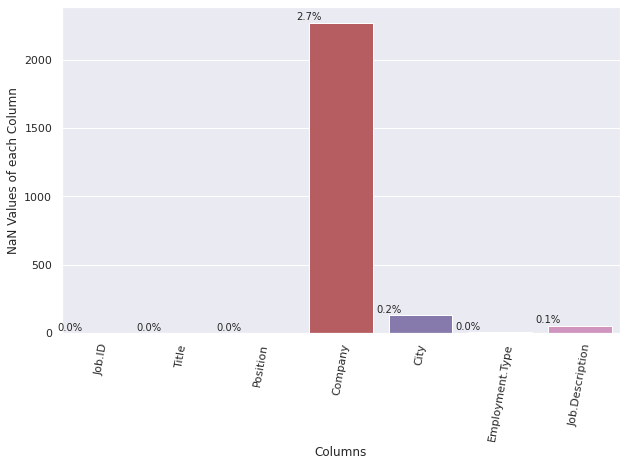

In [53]:
plt.figure(figsize=(10,6))
sns.set()
sns.barplot(x_axis,y_axis)
Xc = plt.gca()
for ptc in Xc.patches:
    hght = ptc.get_height()
    Xc.text(ptc.get_x(),
            hght + 2,
            str(100*round(int(hght)/jobs_df.shape[0], 3)) +"%",
            fontsize=10, ha='center', va='bottom')
Xc.set_xlabel("Columns")
Xc.set_ylabel("NaN Values of each Column")
plt.xticks(rotation=80)

plt.show()

**Cleaning and preprocessing the jobs dataset**

In [54]:
# Fecthing rows which contains City with NaN values
city_NaN = jobs_df[pd.isnull(jobs_df['City'])]
print(city_NaN.shape)
city_NaN.head()

(135, 7)


,Job.ID,Title,Position,Company,City,Employment.Type,Job.Description
3425,142044,Registered Nurse (RN) @ St. Francis Hospital,Registered Nurse (RN),St. Francis Hospital,NaN,Full-Time/Part-Time,Under the direction of the Clinical Coordinato...
3433,142054,Sales Representative - Business Development Op...,Sales Representative - Business Development Op...,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3434,142055,New Business Executive @ CHI Payment Systems,New Business Executive,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3435,142056,Outside Sales Representative (Business Develop...,Outside Sales Representative (Business Develop...,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3436,142057,Outside Sales Representative @ CHI Payment Sys...,Outside Sales Representative,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."


In [55]:
# Grouping by Company to extract company names and searching for their location on the internet
city_NaN.groupby(['Company'])['City'].count()

Company
Academic Year In America                0
CBS Healthcare Services and Staffing    0
CHI Payment Systems                     0
Driveline Retail                        0
Educational Testing Services            0
Genesis Health System                   0
Genesis Health Systems                  0
Home Instead Senior Care                0
St. Francis Hospital                    0
Volvo Group                             0
Name: City, dtype: int64

In [56]:
# Replacing Genesis Health Systems company name with Genesis Health System as they are the same company
jobs_df['Company'] = jobs_df['Company'].replace(['Genesis Health Systems'], 'Genesis Health System')

In [57]:
# Replacing NaN of values of the City with the companies' headquarters location 
jobs_df.loc[jobs_df.Company == 'Academic Year In America', 'City'] = 'Stamford'
jobs_df.loc[jobs_df.Company == 'CBS Healthcare Services and Staffing ', 'City'] = 'Urbandale'
jobs_df.loc[jobs_df.Company == 'CHI Payment Systems', 'City'] = 'Illinois'
jobs_df.loc[jobs_df.Company == 'Driveline Retail', 'City'] = 'Coppell'
jobs_df.loc[jobs_df.Company == 'Educational Testing Services', 'City'] = 'New Jersey'
jobs_df.loc[jobs_df.Company == 'Genesis Health System', 'City'] = 'Davennport'
jobs_df.loc[jobs_df.Company == 'Home Instead Senior Care', 'City'] = 'Nebraska'
jobs_df.loc[jobs_df.Company == 'St. Francis Hospital', 'City'] = 'New York'
jobs_df.loc[jobs_df.Company == 'Volvo Group', 'City'] = 'Washington'
jobs_df.loc[jobs_df.Company == 'CBS Healthcare Services and Staffing', 'City'] = 'Urbandale'

In [58]:
jobs_df.isnull().sum()

Job.ID                0
Title                 0
Position              0
Company            2271
City                  0
Employment.Type      10
Job.Description      56
dtype: int64

In [59]:
jobs_df['Employment.Type'].unique()

array(['Part-Time', 'Full-Time/Part-Time', 'Seasonal/Temp', 'Per Diem',
       'Intern', nan, 'Full-Time', 'Contract', 'Temporary/seasonal'],
      dtype=object)

In [60]:
# As in the unique Employment Types 'Full-Time/Part-Time' exists, it shows ambiguity, which is as inadequate as 
# NaN values, However, it is a value, nonetheless. Thus, replacing the NaN in 'Employment.Type' as Full-Time/Part-Time.  
jobs_df['Employment.Type']=jobs_df['Employment.Type'].fillna('Full-Time/Part-Time')
jobs_df.groupby(['Employment.Type'])['Company'].count()

Employment.Type
Contract                  14
Full-Time                 37
Full-Time/Part-Time    16771
Intern                   904
Part-Time              32188
Per Diem                4514
Seasonal/Temp          27390
Temporary/seasonal         1
Name: Company, dtype: int64

In [61]:
jobs_df[13:18]

,Job.ID,Title,Position,Company,City,Employment.Type,Job.Description
13,134278,"Child Psychotherapist @ CATCH, Inc.",Child Psychotherapist,"CATCH, Inc.",Philadelphia,Full-Time/Part-Time,&nbsp;\r\n\r\n\r\n \r\n Complete\r\n ...
14,134279,Part Time Clerks Needed @ Kroger - Louisville,Part Time Clerks Needed,Kroger - Louisville,Louisville,Part-Time,Exciting Job Opportunities Await YOU at KROGER...
15,134280,Hiring Kitchen Positions - Experienced Line Co...,Hiring Kitchen Positions - Experienced Line Cooks,LongHorn Steakhouse,Southern Pines,Full-Time/Part-Time,"Steer YOUR Success\r\n\r\nAt LongHorn, team me..."
16,134281,HR Administrator @ New York Community Bank,HR Administrator,New York Community Bank,Elizabeth,Part-Time,JOB SUMMARY Provides administrative support fo...
17,134282,"Retail Gift Registry Advisor, Full Time/Part T...","Retail Gift Registry Advisor, Full Time/Part T...",Macy's,Dayton,Full-Time/Part-Time,Job Overview:\r\n\r\nAs a Gift Registry Adviso...


In [62]:
# Replacing NaN value company names with empty space
jobs_df['Company'] = jobs_df['Company'].fillna(' ')

# Replacing NaN of Description column to empty space
jobs_df['Job.Description'] = jobs_df['Job.Description'].fillna(' ')

# Merging 'Position','Company','City','Employment.Type','Job.Description',
# and 'Title' columns and putting them into a new column Text
jobs_df['text'] = jobs_df[['Position','Company','City','Employment.Type','Job.Description',
       'Title']].apply(lambda x: ' '.join(x), axis = 1)

#New Dataset with three columns 'Job.ID', 'text', and 'Title'.
jobs_df_Merged = jobs_df[['Job.ID','text','Title']]

jobs_df_Merged.isnull().sum()

Job.ID    0
text      0
Title     0
dtype: int64

In [63]:
jobs_df_Merged.shape

(84090, 3)

In [64]:
jobs_df_Merged.head()

,Job.ID,text,Title
0,111,Server Tacolicious Palo Alto Part-Time Tacolic...,Server @ Tacolicious
1,113,Kitchen Staff/Chef Claude Lane San Francisco P...,Kitchen Staff/Chef @ Claude Lane
2,117,Bartender Machka Restaurants Corp. San Francis...,Bartender @ Machka Restaurants Corp.
3,121,Server Teriyaki House Brisbane Part-Time ● Se...,Server @ Teriyaki House
4,127,Kitchen Staff/Chef Rosa Mexicano - Sunset Los ...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset


**Preprocessing Text using NLTK libraries and creating Jobs corpus**

In [65]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [66]:
stp = stopwords.words('english')
stp_wrds_ = set(stp)

wrd_net_Lemm = WordNetLemmatizer

# Function to check wheter the tokenised text still has the Stop Words or Punctuations
def Assess_Tokenize(word):
    return word not in stp_wrds_ and word not in list(string.punctuation) and len(word)>2

# Function to Clean the Text, by removing spaces, special characters, tokenizing, and Lemmatizing
def preprocess_text(text):
    
    cleared_text = []
    cleared_text_2 = []
    text = re.sub("'", "",text)
    text = re.sub("(\\d|\\W)+"," ",text) 
    text = text.replace("nbsp", "")
    cleared_text = [ wrd_net_Lemm.lemmatize("",word, pos="v") for word in word_tokenize(text.lower()) if Assess_Tokenize(word)]
    cleared_text_2 = [word for word in cleared_text if Assess_Tokenize(word)]
    return " ".join(cleared_text_2)

In [67]:
# Applying the prerpcessing on the text Column    
jobs_df_Merged['text'] = jobs_df_Merged['text'].apply(preprocess_text)
jobs_df_Merged.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Job.ID,text,Title
0,111,server tacolicious palo alto part time tacolic...,Server @ Tacolicious
1,113,kitchen staff chef claude lane san francisco p...,Kitchen Staff/Chef @ Claude Lane
2,117,bartender machka restaurants corp san francisc...,Bartender @ Machka Restaurants Corp.
3,121,server teriyaki house brisbane part time serve...,Server @ Teriyaki House
4,127,kitchen staff chef rosa mexicano sunset los an...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset


In [97]:
# Initiating TF-IDF ( Term Frequency - Inverse Document Frequency) 
TF_IDF = TfidfVectorizer()

# Fitting and transforming the Text to Feature Vectors
Text_tfidf = TF_IDF.fit_transform((jobs_df_Merged['text'])) 
Text_tfidf

<84090x51497 sparse matrix of type '<class 'numpy.float64'>'
	with 8486332 stored elements in Compressed Sparse Row format>

**Reading the User details dataset and applying NLP preprocessing on the textual data**

Preprocessing Users' Job_views dataset

In [69]:
# Fetching Job View DS, it contains User Job Viewing data
jobView_df = pd.read_csv('/content/drive/MyDrive/Datasets/IndeedDatasets/Job_Views.csv')
jobView_df.head()

,Applicant.ID,Job.ID,Title,Position,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At
0,10000,73666,Cashiers & Valets Needed! @ WallyPark,Cashiers & Valets Needed!,WallyPark,Newark,New Jersey,NJ,NaN,2014-12-12 20:12:35 UTC,2014-12-12 20:31:24 UTC,1129.0,2014-12-12 20:12:35 UTC,2014-12-12 20:12:35 UTC
1,10000,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-12 20:08:50 UTC,2014-12-12 20:10:15 UTC,84.0,2014-12-12 20:08:50 UTC,2014-12-12 20:08:50 UTC
2,10001,84141,Part Time Showroom Sales / Cashier @ Grizzly I...,Part Time Showroom Sales / Cashier,Grizzly Industrial Inc.,Bellingham,Washington,WA,NaN,2014-12-12 20:12:32 UTC,2014-12-12 20:17:18 UTC,286.0,2014-12-12 20:12:32 UTC,2014-12-12 20:12:32 UTC
3,10002,77989,Event Specialist Part Time @ Advantage Sales &...,Event Specialist Part Time,Advantage Sales & Marketing,Simpsonville,South Carolina,SC,NaN,2014-12-12 20:39:23 UTC,2014-12-12 20:42:13 UTC,170.0,2014-12-12 20:39:23 UTC,2014-12-12 20:39:23 UTC
4,10002,69568,Bonefish - Kitchen Staff @ Bonefish Grill,Bonefish - Kitchen Staff,Bonefish Grill,Greenville,South Carolina,SC,NaN,2014-12-12 20:43:25 UTC,2014-12-12 20:43:58 UTC,33.0,2014-12-12 20:43:25 UTC,2014-12-12 20:43:25 UTC


In [70]:
# Only Going to use 'Applicant.ID', 'Position', 'Company', and 'City' variables
jobView_df = jobView_df[['Applicant.ID', 'Job.ID', 'Position', 'Company','City']]
jobView_df.isnull().sum()

Applicant.ID      0
Job.ID            0
Position          0
Company         580
City              0
dtype: int64

In [71]:
# Replacing NaN value of Company with empty space
jobView_df['Company'] = jobView_df['Company'].fillna(' ')

In [72]:
# Merging'Position','Company', and 'City' columns
jobView_df["PosComCity"] = jobView_df[['Position','Company','City']].apply(lambda x: ' '.join(x), axis = 1)

In [73]:
# Cleaning 
jobView_df['PosComCity'] = jobView_df['PosComCity'].map(str).apply(preprocess_text)
jobView_df['PosComCity'] = jobView_df['PosComCity'].str.lower()

jobView_df = jobView_df[['Applicant.ID','PosComCity']]
jobView_df.head()

,Applicant.ID,PosComCity
0,10000,cashier valet need wallypark newark
1,10000,macys seasonal retail fragrance cashier garden...
2,10001,part time showroom sales cashier grizzly indus...
3,10002,event specialist part time advantage sales mar...
4,10002,bonefish kitchen staff bonefish grill greenville


Preprocessing Users' experience dataset


In [74]:
# Fetching User Experience DS, it contains User Experience data
Experience_DS = pd.read_csv('/content/drive/MyDrive/Datasets/IndeedDatasets/Experience.csv')
Experience_DS.head()

,Applicant.ID,Position.Name,Employer.Name,City,State.Name,State.Code,Start.Date,End.Date,Job.Description,Salary,Can.Contact.Employer,Created.At,Updated.At
0,10001,Account Manager / Sales Administration / Quali...,Barcode Resourcing,Bellingham,Washington,WA,2012-10-15,NaN,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
1,10001,Electronics Technician / Item Master Controller,Ryzex Group,Bellingham,Washington,WA,2001-12-01,2012-04-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
2,10001,Machine Operator,comptec inc,Custer,Washington,WA,1997-01-01,1999-01-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
3,10003,maintenance technician,Winn residental,washington,District of Columbia,DC,NaN,NaN,"Necessary maintenance for ""Make Ready"" Plumbin...",10.0,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC
4,10003,Electrical Helper,michael and son services,alexandria,Virginia,VA,NaN,NaN,repair and services of electrical construction,NaN,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC


In [75]:
# Only taking the following columns
Experience_DS= Experience_DS[['Applicant.ID','Position.Name']]

# cleaning the text and creating a corpus
Experience_DS['Position.Name'] = Experience_DS['Position.Name'].map(str).apply(preprocess_text)
Experience_DS.head()

,Applicant.ID,Position.Name
0,10001,account manager sales administration quality a...
1,10001,electronics technician item master controller
2,10001,machine operator
3,10003,maintenance technician
4,10003,electrical helper


In [76]:
# Checking for null
Experience_DS.isnull().sum()

Applicant.ID     0
Position.Name    0
dtype: int64

In [77]:
# Sorting the Data by Applicant ID
Experience_DS =  Experience_DS.sort_values(by='Applicant.ID')
Experience_DS.head()

,Applicant.ID,Position.Name
2763,2,volunteer
2762,2,writer uloop blog
3759,3,market intern
3758,3,server
3757,3,prep cook


In [78]:
# some applicant has multiple applications for different positions, therefore, joining them
Experience_DS = Experience_DS.groupby('Applicant.ID', sort=False)['Position.Name'].apply(' '.join).reset_index()
Experience_DS.head()

,Applicant.ID,Position.Name
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order taker
4,11,cashier


Preprocessing Users' job interests dataset

In [79]:
# Fetching User Interests DS, it contains User interests in certain postions and companies
UserInterest_DS =  pd.read_csv('/content/drive/MyDrive/Datasets/IndeedDatasets/Positions_Of_Interest.csv', sep=',')
UserInterest_DS = UserInterest_DS.sort_values(by='Applicant.ID')
UserInterest_DS.head()

,Applicant.ID,Position.Of.Interest,Created.At,Updated.At
6437,96,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1156,153,Barista,2014-08-14 15:56:43 UTC,2015-02-18 02:35:06 UTC
1155,153,Host,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1154,153,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1158,153,Sales Rep,2014-08-14 15:56:47 UTC,2015-03-02 02:13:08 UTC


In [80]:
# Only taking the following columns
UserInterest_DS = UserInterest_DS[['Applicant.ID','Position.Of.Interest']]

# cleaning the text and creating a corpus
UserInterest_DS['Position.Of.Interest'] = UserInterest_DS['Position.Of.Interest'].map(str).apply(preprocess_text)
UserInterest_DS.head()

,Applicant.ID,Position.Of.Interest
6437,96,server
1156,153,barista
1155,153,host
1154,153,server
1158,153,sales rep


In [81]:
# Checking for null
UserInterest_DS.isnull().sum()

Applicant.ID            0
Position.Of.Interest    0
dtype: int64

In [82]:
# some applicant has multiple Interests for different positions, therefore, joining them
UserInterest_DS = UserInterest_DS.groupby('Applicant.ID', sort=True)['Position.Of.Interest'].apply(' '.join).reset_index()
UserInterest_DS.head()

,Applicant.ID,Position.Of.Interest
0,96,server
1,153,barista host server sales rep customer service...
2,256,host production area sales rep customer servic...
3,438,customer service rep barista host server
4,568,receptionist customer service rep book keeper



**MERGING ALL THE USER DATASETS TO FORM A SINGLE USER DF**

In [83]:
view_exp = jobView_df.merge(Experience_DS, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
view_exp = view_exp.fillna(' ')
view_exp = view_exp.sort_values(by='Applicant.ID')
view_exp.head()

,Applicant.ID,PosComCity,Position.Name
12370,2,,volunteer writer uloop blog
12371,3,,market intern server prep cook
12372,6,,project assistant
12373,8,,deli clerk server cashier food prep order taker
12374,11,,cashier


In [ ]:
view_exp_intrst = view_exp.merge(UserInterest_DS, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
view_exp_intrst = view_exp_intrst.fillna(' ')
view_exp_intrst = view_exp_intrst.sort_values(by='Applicant.ID')

In [90]:
view_exp_intrst[57:62]

,Applicant.ID,PosComCity,Position.Name,Position.Of.Interest
57,96,server sakae sushi burlingame,cashiet waiter receptionist cashier,server
58,96,server waraku san francisco,cashiet waiter receptionist cashier,server
59,96,kitchen staff izakaya yuzuki san francisco,cashiet waiter receptionist cashier,server
60,102,,teachers assistant,
61,103,,sales associate waitress cashier,


In [91]:
# Merge all the columns in view_exp_intrst DF
view_exp_intrst['text'] = view_exp_intrst[['PosComCity','Position.Name','Position.Of.Interest']].apply(lambda x: ' '.join(x), axis = 1)

# Final DF with two columns
Person_DF = view_exp_intrst[['Applicant.ID','text']]
Person_DF.head()

,Applicant.ID,text
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order ta...
4,11,cashier


In [92]:
# cleaning the text and creating a corpus
Person_DF['text'] = Person_DF['text'].apply(preprocess_text)
Person_DF.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Applicant.ID,text
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order taker
4,11,cashier


In [94]:
applicant_id = 326 #applicant id for whom we are going to generate recommendations

In [95]:
Person_DF.columns = ['Applicant_ID','text']
the_applicant = Person_DF.loc[Person_DF.Applicant_ID == applicant_id]
the_applicant

,Applicant_ID,text
186,326,java developer


Feature Extraction on User dataset

In [98]:
# Vectorizing using TF-IDF
applicant_tfidf = TF_IDF.transform(the_applicant['text'])

**Recommendations generated Using Cosine Similarity**

In [99]:
tfidf_cos_sim = map(lambda i: cosine_similarity(applicant_tfidf, i), Text_tfidf)

out = list(tfidf_cos_sim)

# Function to fetch Primary N Recommendations
def Recommendation(prim, merged_job, acc):
  recom = pd.DataFrame(columns = ['Applicant_ID', 'Job_ID',  'Title', 'relevency_score'])
  seq = 0
  for i in prim:
      recom.at[seq, 'Applicant_ID'] = applicant_id
      recom.at[seq, 'Job_ID'] = merged_job['Job.ID'][i]
      recom.at[seq, 'Title'] = merged_job['Title'][i]
      recom.at[seq, 'relevency_score'] =  acc[seq]
      seq += 1
  return recom

prim = sorted(range(len(out)), key=lambda x: out[x], reverse=True)[:20]
scr_list = [out[i][0][0] for i in prim]

# RECOMMENDATIONS GENRATED BY EMPLOYING COSINE SIMILARITY
CS = Recommendation(prim, jobs_df_Merged, scr_list)
CS

,Applicant_ID,Job_ID,Title,relevency_score
0,326,303112,Java Developer @ TransHire,0.750065
1,326,294684,Java Developer @ Kavaliro,0.739756
2,326,269922,Entry Level Java Developer / Jr. Java Develope...,0.73683
3,326,141831,Lead Java/J2EE Developer - Contract to Hire @ ...,0.670751
4,326,270171,Senior Java Developer - Contract to Hire - Gre...,0.644073
5,326,305264,Sr. Java Developer @ Paladin Consulting Inc,0.624724
6,326,309945,"Java Software Engineer @ iTech Solutions, Inc.",0.591391
7,326,245753,Java Administrator @ ConsultNet,0.530084
8,326,146640,Jr. Java Developer @ Paladin Consulting Inc,0.509806
9,326,150882,Java Consultant - Mobile Apps Development @ Co...,0.487654


**Recommendations generated Using K Nearest Neighbors**

In [100]:
# K Nearest Neighbors
neighbors = 21
K_NN = NearestNeighbors(neighbors, p=2)
K_NN.fit(Text_tfidf)
N_Ns = K_NN.kneighbors(applicant_tfidf, return_distance=True)

prim = N_Ns[1][0][1:]
rel_scr_list = N_Ns[0][0][1:]

# RECOMMENDATIONS GENRATED BY EMPLOYING KNN
KNN = Recommendation(prim, jobs_df_Merged, rel_scr_list)
KNN

,Applicant_ID,Job_ID,Title,relevency_score
0,326,294684,Java Developer @ Kavaliro,0.721449
1,326,269922,Entry Level Java Developer / Jr. Java Develope...,0.725493
2,326,141831,Lead Java/J2EE Developer - Contract to Hire @ ...,0.811479
3,326,270171,Senior Java Developer - Contract to Hire - Gre...,0.843714
4,326,305264,Sr. Java Developer @ Paladin Consulting Inc,0.866344
5,326,309945,"Java Software Engineer @ iTech Solutions, Inc.",0.904001
6,326,245753,Java Administrator @ ConsultNet,0.969449
7,326,146640,Jr. Java Developer @ Paladin Consulting Inc,0.990145
8,326,150882,Java Consultant - Mobile Apps Development @ Co...,1.01227
9,326,284085,SENIOR JAVA ENGINEER,1.0357
